1. cdp_backtest() => 

從2020-01-01開始四年/一年/2024-01-01 ~ 2024-03-08 三個區段的return/ buy-and-hold return/ winrate、四年回測的圖表

2. cdp_backtest_all() => 

cdp_backtest() 的結果，tickers = 全部股票，可以輸出到excel的版本

3. cdp_backtest_all_check_what_elements_to_be_considered(days=day) => 

比起 cdp_backtest_all() 加上可以選擇要從2020-01-01再過去{day}天回測，可以當作找因子的公式

In [ ]:
# daily decision version
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
def calculate_cdp_for_the_day(ticker):
    a = yf.download(ticker, start="2024-02-28", interval='1d', progress=False)
    a['typical'] = (a['Close']*2 + a['High'] + a['Low'])/4
    a['typical'] = a['typical']
    a['PT'] = (a['High'] - a['Low'])
    a["AH"] = a['typical'] + a['PT']
    a['NH'] = a['typical']*2 - a['Low']
    a['NL'] = a['typical']*2 - a['High']
    a["AL"] = a['typical'] - a['PT']
    return a
for ticker in ['TSM', "QCOM", "MU", "NVDA", "AMD"]:
    s = calculate_cdp_for_the_day(ticker=ticker)
    print(ticker)    
    print(s[['AH', "NH", "NL", "AL", "Close"]].tail(1))

In [23]:
# functions
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import tqdm
def cdp_backtest(show_table=False, ticker='NVDA', debug=True, show_backtest = True, fee=0.05, start="2023-01-01", end=datetime.now(), hold_time = 0):
    a = yf.download(ticker, start=start, end= end, interval='1d', progress=False)

    # data cleaning
    a['typical'] = (a['Close']*2 + a['High'] + a['Low'])/4
    a['typical'] = a['typical'].shift(1)
    a['PT'] = (a['High'] - a['Low'])
    a["AH"] = a['typical'] + a['PT']
    a['NH'] = a['typical']*2 - a['Low']
    a['NL'] = a['typical']*2 - a['High']
    a["AL"] = a['typical'] - a['PT']
    # a['typical'] = a['typical'].shift(1)
    a.dropna(inplace=True)

    # get signal
    open = list(a['Open'])
    close = list(a['Close'])
    high = list(a['High'])
    low = list(a['Low'])
    typical = list(a['typical'])
    ah = list(a['AH'])
    nh = list(a['NH'])
    nl = list(a['NL'])
    al = list(a['AL'])
    comment = []
    signal = []
    max_dwardown = []
    for i in range(len(a)):
        if(open[i] > ah[i]):
            comment.append("trend buy")
            signal.append(4)
        elif(ah[i] > open[i] > nh[i]):
            comment.append("reverse sell")
            signal.append(3)
        elif(nh[i] > open[i] > nl[i]):
            comment.append("nothing")
            signal.append(2)
        elif(nl[i] > open[i] > al[i]):
            comment.append("reverse buy")
            signal.append(1)
        elif(al[i] > open[i]):
            comment.append("trend sell")
            signal.append(0)
        else:
            comment.append("error")
            signal.append(-1)
    a['signal'] = signal
    a['comment'] = comment

    # calculate backtest result v.s. buy and hold return
    signals = list(a['signal'])
    profits = []
    buy_and_hold = []
    if hold_time == 0:
        for i in range(len(a)):
            # calculate buy-and-hold return graph
            buy_and_hold.append(close[i]/open[0])
            # trend buy and reverse sell => buy
            if(signals[i] == 3 or signals[i] == 4):
                mdd = (low[i] - open[i])/open[i]
                profit = (1 + (close[i] - open[i])/open[i])*(1-fee)
            # trend sell and reverse buy => sell
            elif(signals[i] == 0 or signals[i] == 1):
                # sell
                mdd = (open[i] - high[i])/open[i]
                profit = (1 + (open[i] - close[i])/open[i])*(1-fee)
            
            elif(signals[i] == 2 or signals[i] == -1):
                #do nothing
                profit = 1
                mdd = 0
            max_dwardown.append(np.round(mdd, 3))
            profits.append(np.round(profit, 3))
    elif hold_time == 1:
        for i in range(len(a)):
            # calculate buy-and-hold return graph
            buy_and_hold.append(close[i]/open[0])
            # trend buy and reverse sell => buy
            if(signals[i] == 0 or signals[i] == 1):
                mdd = (low[i] - open[i])/open[i]
                profit = (1 + (open[i+1] - open[i])/open[i])*(1-fee)
            # trend sell and reverse buy => sell
            elif(signals[i] == 3 or signals[i] == 4):
                # sell
                mdd = (open[i] - high[i])/open[i]
                profit = (1 + (open[i] - open[i+1])/open[i])*(1-fee)
            
            elif(signals[i] == 2 or signals[i] == -1):
                #do nothing
                profit = 1
                mdd = 0
            max_dwardown.append(np.round(mdd, 3))
            profits.append(np.round(profit, 3))
        # elif(signals[i] == 3):
        #     #buy

        # elif(signals[i] == 4):
        #     # sell
        #     mdd = (open[i] - high[i])/open[i]
        #     profit = (1 + (open[i] - close[i])/open[i])*(1-fee)

    result = np.cumsum(np.log(profits))
    for i in range(len(result)):
        result[i] = result[i] + 1
    a['result'] = result
    a['daily_profit'] = profits
    a['buy_and_hold'] = buy_and_hold
    a['mdd'] = max_dwardown
    #debug
    res_db = a[["Open", "Close", "High", "comment", "daily_profit", "mdd"]]
    if debug == True and show_table == True:
        
        print(res_db[res_db['comment'] != "nothing"].tail(20))

    # calculation for compounded return & non-compounded return
    comp_return = []
    non_comp_return = []
    return_comprod = 1.0
    return_non_comp = 1.0
    for i in list(a['daily_profit']):
        return_comprod *= i
        return_non_comp += (i - 1)
        comp_return.append(return_comprod)
        non_comp_return.append(return_non_comp)
    a['comp_ret'] = comp_return
    a['non_comp_ret'] = non_comp_return
    print("Buy and hold: ", list(a['buy_and_hold'])[-1])
    print("Non comp return: ", list(a['non_comp_ret'])[-1])
    if debug != True:
        # plotting
        fig, ax = plt.subplots()
        # ax.plot(a['comp_ret'], label='compounded return', color='r')
        ax.plot(a['non_comp_ret'], label='non compounded return', color='y')
        
        # 雖然圖線重疊，但這樣刻度才對
        ax.plot(a['buy_and_hold'], label='buy and hold return', color = 'blue')
        ax2 = ax.twinx()
        ax2.plot(a['Close'], label='close', color='black')
        ax.legend()
        plt.title(f"{ticker} cumsum vs price")
        plt.show()
    print(ticker)
    # show backtest results
    win = a[a['daily_profit'] > 1]
    lose = a[a['daily_profit'] < 1]
    nothing = a[a['daily_profit'] == 1]
    if show_backtest == True:
        if (len(nothing)+len(lose)+len(win) != len(a)):
            print("win-lose-nothing classification incorrect")
        print("===============================")
        print("total strong buy trend days: ", len(a[a['comment'] == "trend buy"])) 
        print("total reverse sell days: ", len(a[a['comment'] == "reverse sell"]))
        print("total reverse buy days: ", len(a[a['comment'] == "reverse buy"]))
        print("total strong sell trend days: ", len(a[a['comment'] == "trend sell"]))   
        print("-------------------------------")
        print("total trading days: ", len(a))
        print("total win days: ", len(win))
        print("total lose days: ", len(lose))
        print("total no-action days: ", len(nothing))

    print("winrate: ", np.round(len(win)/(len(win) + len(lose))*100, 2), "%")
    print("===============================")
    return a

def cdp_backtest_all(tickers=['NVDA'], fee=0.05, start="2020-01-01", hold_time = 0):
    loop = 0
    with tqdm.tqdm(total=len(tickers)) as pbar:
        for ticker in tickers:

            a = yf.download(ticker, start=start, interval='1d', progress=False)

            # data cleaning
            a['typical'] = (a['Close']*2 + a['High'] + a['Low'])/4
            a['typical'] = a['typical'].shift(1)
            a['PT'] = (a['High'] - a['Low'])
            a["AH"] = a['typical'] + a['PT']
            a['NH'] = a['typical']*2 - a['Low']
            a['NL'] = a['typical']*2 - a['High']
            a["AL"] = a['typical'] - a['PT']
            a.dropna(inplace=True)

            # get signal
            open = list(a['Open'])
            close = list(a['Close'])
            high = list(a['High'])
            low = list(a['Low'])
            typical = list(a['typical'])
            ah = list(a['AH'])
            nh = list(a['NH'])
            nl = list(a['NL'])
            al = list(a['AL'])
            comment = []
            signal = []
            max_dwardown = []
            for i in range(len(a)):
                if(open[i] > ah[i]):
                    comment.append("trend buy")
                    signal.append(4)
                elif(ah[i] > open[i] > nh[i]):
                    comment.append("reverse sell")
                    signal.append(3)
                elif(nh[i] > open[i] > nl[i]):
                    comment.append("nothing")
                    signal.append(2)
                elif(nl[i] > open[i] > al[i]):
                    comment.append("reverse buy")
                    signal.append(1)
                elif(al[i] > open[i]):
                    comment.append("trend sell")
                    signal.append(0)
                else:
                    comment.append("error")
                    signal.append(-1)
            a['signal'] = signal
            a['comment'] = comment

            # calculate backtest result v.s. buy and hold return
            signals = list(a['signal'])
            profits = []
            buy_and_hold = []
            if hold_time == 0:
                for i in range(len(a)):
                    # calculate buy-and-hold return graph
                    buy_and_hold.append(close[i]/open[0])
                    # trend buy and reverse sell => buy
                    if(signals[i] == 3 or signals[i] == 4):
                        mdd = (low[i] - open[i])/open[i]
                        profit = (1 + (close[i] - open[i])/open[i])*(1-fee)
                    # trend sell and reverse buy => sell
                    elif(signals[i] == 0 or signals[i] == 1):
                        # sell
                        mdd = (open[i] - high[i])/open[i]
                        profit = (1 + (open[i] - close[i])/open[i])*(1-fee)
                    
                    elif(signals[i] == 2 or signals[i] == -1):
                        #do nothing
                        profit = 1
                        mdd = 0
                    max_dwardown.append(np.round(mdd, 3))
                    profits.append(np.round(profit, 3))
            elif hold_time == 1:
                for i in range(len(a)):
                    # calculate buy-and-hold return graph
                    buy_and_hold.append(close[i]/open[0])
                    # trend buy and reverse sell => buy
                    if(signals[i] == 0 or signals[i] == 1):
                        mdd = (low[i] - open[i])/open[i]
                        profit = (1 + (open[i+1] - open[i])/open[i])*(1-fee)
                    # trend sell and reverse buy => sell
                    elif(signals[i] == 3 or signals[i] == 4):
                        # sell
                        mdd = (open[i] - high[i])/open[i]
                        profit = (1 + (open[i] - open[i+1])/open[i])*(1-fee)
                    
                    elif(signals[i] == 2 or signals[i] == -1):
                        #do nothing
                        profit = 1
                        mdd = 0
                    max_dwardown.append(np.round(mdd, 3))
                    profits.append(np.round(profit, 3))

            result = np.cumsum(np.log(profits))
            for i in range(len(result)):
                result[i] = result[i] + 1
            a['result'] = result
            a['daily_profit'] = profits
            a['buy_and_hold'] = buy_and_hold
            a['mdd'] = max_dwardown

            # calculation for compounded return & non-compounded return
            comp_return = []
            non_comp_return = []
            return_comprod = 1.0
            return_non_comp = 1.0
            for i in list(a['daily_profit']):
                return_comprod *= i
                return_non_comp += (i - 1)
                comp_return.append(return_comprod)
                non_comp_return.append(return_non_comp)
            a['comp_ret'] = comp_return
            a['non_comp_ret'] = non_comp_return

            four_year = a
            one_year = a.iloc[-296:-46, :]
            year_td = a.iloc[-46:, :]

            buy_hold_4y = (list(four_year["buy_and_hold"])[-1] - list(four_year["buy_and_hold"])[0])/list(four_year["buy_and_hold"])[0] + 1
            buy_hold_1y = (list(one_year["buy_and_hold"])[-1] - list(one_year["buy_and_hold"])[0])/list(one_year["buy_and_hold"])[0] + 1
            buy_hold_td = (list(year_td["buy_and_hold"])[-1] - list(year_td["buy_and_hold"])[0])/list(year_td["buy_and_hold"])[0] + 1

            win_4y = a[a['daily_profit'] > 1]
            win_1y = one_year[one_year['daily_profit'] > 1]
            win_td = year_td[year_td['daily_profit'] > 1]
            
            lose_4y = a[a['daily_profit'] < 1]
            lose_1y = one_year[one_year['daily_profit'] < 1]
            lose_td = year_td[year_td['daily_profit'] < 1]

            win_rate_4y = np.round(len(win_4y)/(len(win_4y) + len(lose_4y))*100, 2)
            win_rate_1y = np.round(len(win_1y)/(len(win_1y) + len(lose_1y))*100, 2)
            win_rate_td = np.round(len(win_td)/(len(win_td) + len(lose_td))*100, 2)
            
            non_comp_4y = list(a['non_comp_ret'])[-1]
            non_comp_1y = list(year_td["result"])[-1] - list(year_td["result"])[0] + 1
            non_comp_td = list(one_year["result"])[-1] - list(one_year["result"])[0] + 1

            column_name = ["winrate_4y", "return_4y", "buyhold_4y", "winrate_1y", "return_1y", "buyhold_1y", "winrate_td", "return_td", "buyhold_td"]
            rows =        [ win_rate_4y , non_comp_4y,  buy_hold_4y,  win_rate_1y, non_comp_1y,  buy_hold_1y,  win_rate_td, non_comp_td, buy_hold_td ]
            if loop == 0:
                data = pd.DataFrame()
                data['ticker'] = column_name
                loop += 1
            data[ticker] = rows
            pbar.update(1)
    sc = data.T.reset_index()
    sc.columns = sc.iloc[0]
    sc = sc.drop(0)
    sc
    return sc

def cdp_backtest_all_check_what_elements_to_be_considered(tickers=['NVDA'], fee=0.05, start="2020-01-01", hold_time = 0, days=90):
    loop = 0
    with tqdm.tqdm(total=len(tickers)) as pbar:
        for ticker in tickers:
            print(ticker)
            a = yf.download(ticker, start=datetime.now() - timedelta(days=1529-730) - timedelta(days=days), end=datetime.now() - timedelta(days=days), interval='1d', progress=False)

            # data cleaning
            a['typical'] = (a['Close']*2 + a['High'] + a['Low'])/4
            a['typical'] = a['typical'].shift(1)
            a['PT'] = (a['High'] - a['Low'])
            a["AH"] = a['typical'] + a['PT']
            a['NH'] = a['typical']*2 - a['Low']
            a['NL'] = a['typical']*2 - a['High']
            a["AL"] = a['typical'] - a['PT']
            a.dropna(inplace=True)

            # get signal
            open = list(a['Open'])
            close = list(a['Close'])
            high = list(a['High'])
            low = list(a['Low'])
            ah = list(a['AH'])
            nh = list(a['NH'])
            nl = list(a['NL'])
            al = list(a['AL'])
            signal = []
            max_dwardown = []
            for i in range(len(a)):
                if(open[i] > ah[i]):
                    signal.append(4)
                elif(ah[i] > open[i] > nh[i]):
                    signal.append(3)
                elif(nh[i] > open[i] > nl[i]):
                    signal.append(2)
                elif(nl[i] > open[i] > al[i]):
                    signal.append(1)
                elif(al[i] > open[i]):
                    signal.append(0)
                else:
                    signal.append(-1)
            a['signal'] = signal

            # calculate backtest result v.s. buy and hold return
            signals = list(a['signal'])
            profits = []
            buy_and_hold = []
            if hold_time == 0:
                for i in range(len(a)):
                    # calculate buy-and-hold return graph
                    buy_and_hold.append(close[i]/open[0])
                    # trend buy and reverse sell => buy
                    if(signals[i] == 3 or signals[i] == 4):
                        mdd = (low[i] - open[i])/open[i]
                        profit = (1 + (close[i] - open[i])/open[i])*(1-fee)
                    # trend sell and reverse buy => sell
                    elif(signals[i] == 0 or signals[i] == 1):
                        # sell
                        mdd = (open[i] - high[i])/open[i]
                        profit = (1 + (open[i] - close[i])/open[i])*(1-fee)
                    
                    elif(signals[i] == 2 or signals[i] == -1):
                        #do nothing
                        profit = 1
                        mdd = 0
                    max_dwardown.append(np.round(mdd, 3))
                    profits.append(np.round(profit, 3))

            result = np.cumsum(np.log(profits))
            for i in range(len(result)):
                result[i] = result[i] + 1
            a['result'] = result
            a['daily_profit'] = profits
            a['buy_and_hold'] = buy_and_hold
            a['mdd'] = max_dwardown

            # calculation for compounded return & non-compounded return
            comp_return = []
            non_comp_return = []
            return_comprod = 1.0
            return_non_comp = 1.0
            for i in list(a['daily_profit']):
                return_comprod *= i
                return_non_comp += (i - 1)
                comp_return.append(return_comprod)
                non_comp_return.append(return_non_comp)
            a['comp_ret'] = comp_return
            a['non_comp_ret'] = non_comp_return

            one_year = a.iloc[-296:-46, :]
            year_td = a.iloc[-46:, :]

            buy_hold_4y = (buy_and_hold[-1] - buy_and_hold[0])/buy_and_hold[0] + 1
            buy_hold_1y = (buy_and_hold[-46] - buy_and_hold[-296])/buy_and_hold[-296] + 1
            buy_hold_td = (buy_and_hold[-1] - buy_and_hold[-46])/buy_and_hold[-46] + 1

            win_4y = a[a['daily_profit'] > 1]
            win_1y = one_year[one_year['daily_profit'] > 1]
            win_td = year_td[year_td['daily_profit'] > 1]
            
            lose_4y = a[a['daily_profit'] < 1]
            lose_1y = one_year[one_year['daily_profit'] < 1]
            lose_td = year_td[year_td['daily_profit'] < 1]

            win_rate_4y = np.round(len(win_4y)/(len(win_4y) + len(lose_4y))*100, 2)
            win_rate_1y = np.round(len(win_1y)/(len(win_1y) + len(lose_1y))*100, 2)
            win_rate_td = np.round(len(win_td)/(len(win_td) + len(lose_td))*100, 2)
            
            non_comp_4y = list(a['non_comp_ret'])[-1]
            non_comp_1y = list(year_td["result"])[-1] - list(year_td["result"])[0] + 1
            non_comp_td = list(one_year["result"])[-1] - list(one_year["result"])[0] + 1

            column_name = ["winrate_4y", "return_4y", "buyhold_4y", "winrate_1y", "return_1y", "buyhold_1y", "winrate_td", "return_td", "buyhold_td"]
            rows =        [ np.round(win_rate_4y, 2) , np.round(non_comp_4y, 2),  np.round(buy_hold_4y, 2),  \
                           np.round(win_rate_1y, 2),  np.round(non_comp_1y, 2),  np.round(buy_hold_1y, 2),  \
                            np.round(win_rate_td, 2), np.round(non_comp_td, 2), np.round(buy_hold_td, 2) ]
            if loop == 0:
                data = pd.DataFrame()
                data['ticker'] = column_name
                loop += 1
            data[ticker] = rows
            pbar.update(1)
    sc = data.T.reset_index()
    sc.columns = sc.iloc[0]
    sc = sc.drop(0)
    sc
    return sc

trend = ["NVDA", "AMD", "QCOM", "TSM", "COIN", "MSTR", "ARM"]
defensive = ['MCD', "C", "GS", "WBD", "NFLX"]
holding = ["AZEK", "CYBR", "GFF", "KKR", "RL", "TAP", "TW", "EVN", "NVRI"]
custom = ['6799.TW', "2330.TW", "4908.TWO"]
# C GS WBD NFLX
# no env ["AZEK", "CYBR", "GFF", "KKR", "RL", "TAP", "TW", "EVN", "NVRI"]

Buy and hold:  0.3186570134019805
Non comp return:  9.069999999999995


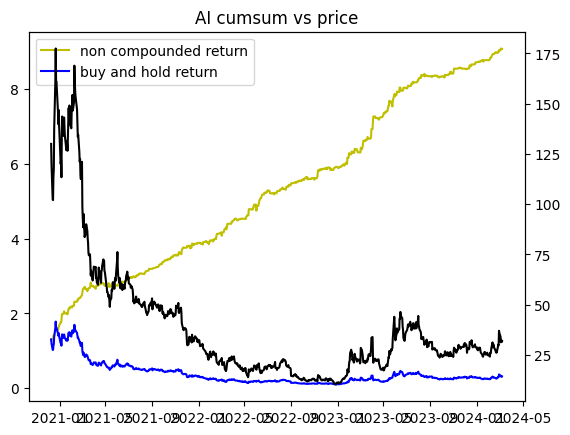

AI
total strong buy trend days:  8
total reverse sell days:  197
total reverse buy days:  207
total strong sell trend days:  15
-------------------------------
total trading days:  815
total win days:  282
total lose days:  143
total no-action days:  390
winrate:  66.35 %
Buy and hold:  1.4038972927390752
Non comp return:  3.787999999999997


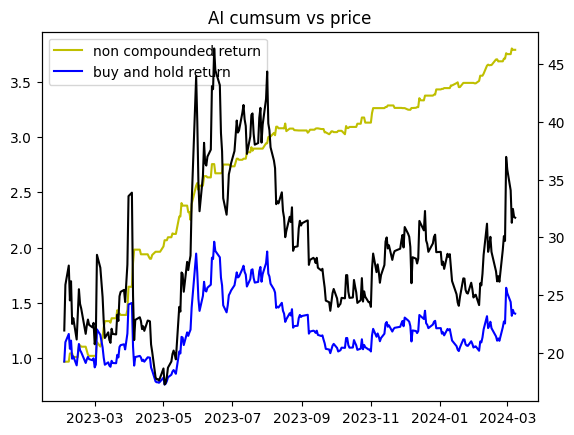

AI
total strong buy trend days:  3
total reverse sell days:  70
total reverse buy days:  54
total strong sell trend days:  8
-------------------------------
total trading days:  276
total win days:  83
total lose days:  51
total no-action days:  142
winrate:  61.94 %
Buy and hold:  1.2991803794482557
Non comp return:  1.3029999999999993


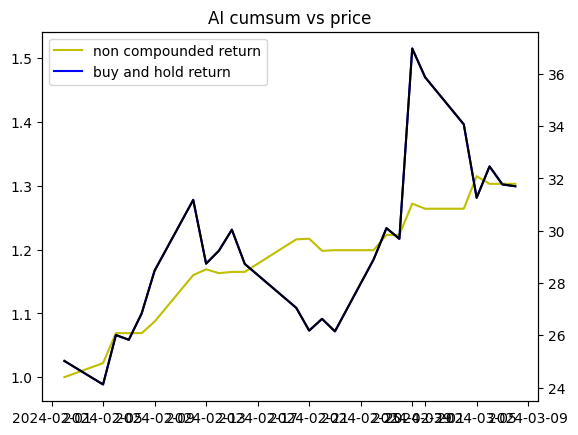

AI
total strong buy trend days:  2
total reverse sell days:  7
total reverse buy days:  6
total strong sell trend days:  1
-------------------------------
total trading days:  25
total win days:  12
total lose days:  4
total no-action days:  9
winrate:  75.0 %
2


,Open,High,Low,Close,Adj Close,Volume,typical,PT,AH,NH,NL,AL,signal,comment,result,daily_profit,buy_and_hold,mdd,comp_ret,non_comp_ret
Date,,,,,,,,,,,,,,,,,,,,
2024-02-02,24.400000,25.150000,24.309999,25.020000,25.020000,4803200,24.71500,0.840000,25.555000,25.120001,24.280001,23.875000,2,nothing,1.000000,1.000,1.025410,0.000,1.000000,1.000
2024-02-05,24.719999,24.809999,23.754999,24.120001,24.120001,4549600,24.87500,1.055000,25.930000,25.995001,24.940001,23.820000,1,reverse buy,1.021761,1.022,0.988525,-0.004,1.022000,1.022
2024-02-06,24.799999,26.225000,24.495001,26.010000,26.010000,8990300,24.20125,1.730000,25.931250,23.907499,22.177500,22.471251,3,reverse sell,1.067690,1.047,1.065984,-0.012,1.070034,1.069
2024-02-07,25.730000,26.305000,25.160000,25.830000,25.830000,6103300,25.68500,1.145000,26.830001,26.210001,25.065001,24.540000,2,nothing,1.067690,1.000,1.058607,0.000,1.070034,1.069
2024-02-08,25.830000,27.350000,25.610001,26.840000,26.840000,7610300,25.78125,1.740000,27.521250,25.952499,24.212500,24.041250,2,nothing,1.067690,1.000,1.100000,0.000,1.070034,1.069
2024-02-09,27.900000,29.629999,27.350000,28.469999,28.469999,14791700,26.66000,2.279999,28.939999,25.970000,23.690001,24.380002,3,reverse sell,1.085530,1.018,1.166803,-0.020,1.089295,1.087
2024-02-12,29.000000,31.549999,28.700001,31.180000,31.180000,15340900,28.48000,2.849998,31.329998,28.259998,25.410000,25.630001,3,reverse sell,1.155989,1.073,1.277869,-0.010,1.168813,1.160
2024-02-13,29.049999,30.230000,28.290001,28.740000,28.740000,10977400,30.65250,1.939999,32.592499,33.014999,31.075001,28.712502,1,reverse buy,1.164949,1.009,1.177869,-0.041,1.179332,1.169
2024-02-14,29.370001,29.790001,28.662001,29.240000,29.240000,6817500,29.00000,1.128000,30.128000,29.337999,28.209999,27.872000,3,reverse sell,1.158930,0.994,1.198361,-0.024,1.172256,1.163


In [3]:
# signal version
a = cdp_backtest(show_table = False, ticker="AI", debug=False, show_backtest=True, fee=0.002, start='2020-02-01', hold_time=0)
a = cdp_backtest(show_table = False, ticker="AI", debug=False, show_backtest=True, fee=0.002, start='2023-02-01', hold_time=0)
a = cdp_backtest(show_table = False, ticker="AI", debug=False, show_backtest=True, fee=0.002, start='2024-02-01', hold_time=0)

# reverse cdp => trend buy, reverse buy = sell, reverse sell, trend sell = buy
print(len(a[a["comment"] == "trend buy"]))
trend_buy = a[a["comment"] == "trend buy"]
# trend_buy[['Open', "Close"]]
a[a['daily_profit'] > 1].head(25)
a

In [93]:
import json
route = '../'
filemap = {
    "NYSE"  : route + "../Database/zackRanks_NYSE.json", # 1352
    "NASDAQ": route + '../Database/zackRanks_NASDAQ.json', # small:1255; mid:330; large:72
    "SP500" : route + "../Database/zackRanks_SP500.json", # small: 1352
   "Yuanta": route + "zackRanks_yuanta.json",
   "portfolio": route + "zackRanks_portfolio.json"
}
with open(filemap["SP500"], 'r') as f:
    python_dict = json.load(f)
    a = list(python_dict.keys())

trend = ["NVDA", "AMD", "QCOM", "TSM", "COIN", "MSTR", "ARM"]
defensive = ['MCD', "C", "GS", "WBD", "NFLX"]
holding = ["AZEK", "CYBR", "GFF", "KKR", "RL", "TAP", "TW", "EVN", "NVRI"]
custom = ['6799.TW', "2330.TW", "4908.TWO"]
# hold_tiome = 1還不行
asss = cdp_backtest_all(tickers=trend, fee=0.002, start = "2020-01-01", hold_time = 0)
asss
# C GS WBD NFLX
# no env ["AZEK", "CYBR", "GFF", "KKR", "RL", "TAP", "TW", "EVN", "NVRI"]

100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


,ticker,winrate_4y,return_4y,buyhold_4y,winrate_1y,return_1y,buyhold_1y,winrate_td,return_td,buyhold_td
1,NVDA,59.61,5.356,15.701952,56.12,1.244375,3.459448,57.14,1.60681,1.923871
2,AMD,61.62,5.666,4.249589,60.42,1.302461,2.143211,59.26,2.061119,1.526234
3,QCOM,57.28,3.47,1.974037,48.98,1.129321,1.25733,60.61,1.235891,1.248406
4,TSM,56.17,2.565,2.508558,49.14,1.074313,1.33032,60.71,1.047168,1.453997
5,COIN,60.1,5.909,0.786873,60.61,1.134807,4.161273,43.75,2.703494,1.668178
6,MSTR,62.8,9.121,9.511214,58.57,1.936856,4.150915,81.25,2.474184,2.163859
7,ARM,67.74,2.034,2.18856,74.29,1.492233,1.134486,59.26,1.601317,1.957812


Buy and hold:  2.2163533632668027
Non comp return:  2.806999999999979
GE
winrate:  57.1 %
Buy and hold:  2.76136745972416
Non comp return:  2.140999999999976
NXPI
winrate:  53.78 %
Buy and hold:  4.036656803871269
Non comp return:  3.705999999999979
URI
winrate:  56.42 %
Buy and hold:  1.0901227547010237
Non comp return:  3.066999999999981
CNC
winrate:  56.42 %
Buy and hold:  2.7477699258272406
Non comp return:  1.4289999999999794
GWW
winrate:  50.63 %
Buy and hold:  0.6625259078242735
Non comp return:  1.72999999999998
D
winrate:  50.7 %
Buy and hold:  0.8636294529413627
Non comp return:  1.8909999999999847
CHTR
winrate:  47.18 %
Buy and hold:  2.8981145199140954
Non comp return:  1.6079999999999786
ACGL
winrate:  49.86 %
Buy and hold:  1.2081218987654336
Non comp return:  1.3869999999999836
PEG
winrate:  46.31 %
Buy and hold:  7.061260390265355
Non comp return:  2.4019999999999824
PWR
winrate:  48.51 %
Buy and hold:  1.0128673382259332
Non comp return:  2.718999999999984
EIX
winrate:

[*********************100%%**********************]  1 of 1 completed


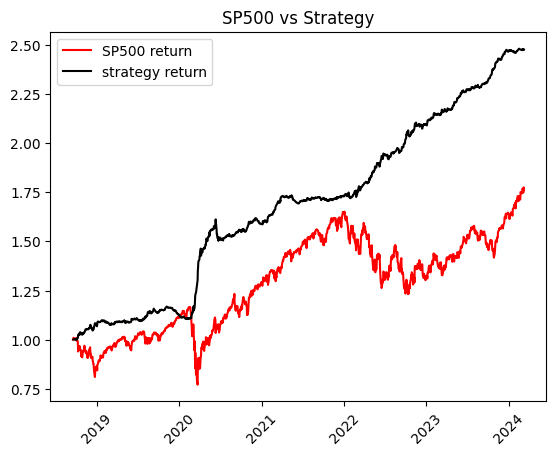

In [127]:
# 回測策略
days_0 = ["GEHC", "HUBB", "GE", "CHTR", "MAR", "D", "FMC", "MPC", "EBAY", "EIX", "OMC", "BR"] ## "UBER", "ABNB", 
days_90 = ["GE", "UBER", "ABNB", "NXPI", "URI", "CNC", "GWW", "D", "CHTR", "ACGL", "PEG", "PWR", "EIX", "AWK", "WBD", "RJF", "FE", "FDS", "CCL", "EG", "WBA", "MAS", "DPZ", "LW", "SWK", "UAL", "GEN", "BG", "IPG", "TRMB", "MKTX", "PARA", "ZION", "DVA"]
days_180 = ["AEE", "AZO", "CMS", "D", "DUK", "DVA", "ES", "FE", "GE", "T", "UAL", "WBD", "ZBRA"]
return_lists = {}
for ticker in days_90:
    a = cdp_backtest(show_table = False, ticker=ticker, debug=True, show_backtest=False, fee=0.005, start=datetime.now() - timedelta(days=2000), end=datetime.now() - timedelta(days=0)) # end=datetime.now() - timedelta(days=90)
    return_lists[ticker] = list(a['result'])
for ticker in days_90:
    print(ticker, len(return_lists[ticker]))
# pd.DataFrame(return_lists, index=a.index)
# return_lists
s = pd.DataFrame(return_lists, index=a.index)
s['result'] = (list(s.sum(axis=1)))
s['result_v2'] = s['result']/len(days_90)

sp = yf.download("^GSPC", start=datetime.now() - timedelta(days=2000), end=datetime.now() - timedelta(days=0))
# def return_func(sp):
#     return sp['Close'] - sp['Close_1']
sp['return'] = sp['Close']/list(sp['Close'])[0]
plt.plot(sp['return'], label='SP500 return', color='red')
plt.plot(s['result_v2'], label='strategy return', color='black')
plt.xticks(rotation=45)
plt.legend()
plt.title("SP500 vs Strategy")
plt.show()

Buy and hold:  1.464469466723361
Non comp return:  1.3159999999999972


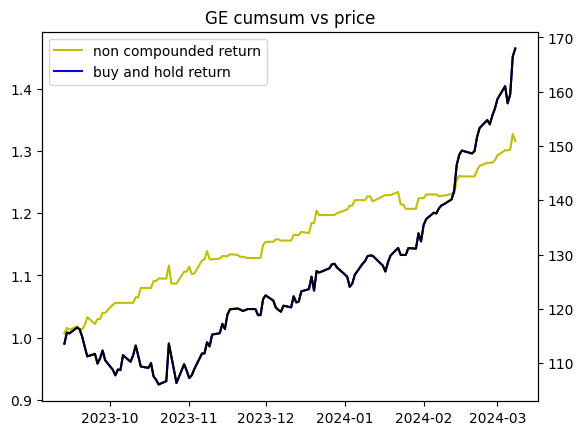

GE
total strong buy trend days:  1
total reverse sell days:  50
total reverse buy days:  23
total strong sell trend days:  0
-------------------------------
total trading days:  123
total win days:  52
total lose days:  18
total no-action days:  53
winrate:  74.29 %


,Open,High,Low,Close,Adj Close,Volume,typical,PT,AH,NH,NL,AL,signal,comment,result,daily_profit,buy_and_hold,mdd,comp_ret,non_comp_ret
Date,,,,,,,,,,,,,,,,,,,,
2023-09-13,114.690002,115.360001,112.639999,113.599998,113.447060,2800200,115.205000,2.720001,117.925001,117.770000,115.049999,112.484999,1,reverse buy,1.006976,1.007,0.990496,-0.006,1.007000,1.007
2023-09-14,114.370003,117.209999,114.320000,115.650002,115.494308,5297500,113.799999,2.889999,116.689999,113.279999,110.389999,110.910000,3,reverse sell,1.015935,1.009,1.008370,-0.000,1.016063,1.016
2023-09-15,115.419998,115.910004,114.199997,115.489998,115.334518,6731300,115.707500,1.710007,117.417507,117.215004,115.504997,113.997494,1,reverse buy,1.012931,0.997,1.006975,-0.004,1.013015,1.013
2023-09-18,115.779999,117.430000,114.919998,116.570000,116.413063,3751700,115.272499,2.510002,117.782501,115.625000,113.114998,112.762497,3,reverse sell,1.017918,1.005,1.016392,-0.007,1.018080,1.018
2023-09-19,116.019997,116.680000,115.220001,116.209999,116.053551,3098200,116.372499,1.459999,117.832499,117.524998,116.064999,114.912500,1,reverse buy,1.013910,0.996,1.013253,-0.006,1.014008,1.014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-04,159.369995,161.770004,158.580002,161.009995,161.009995,6705700,158.372498,3.190002,161.562500,158.164993,154.974991,155.182495,3,reverse sell,1.297381,1.008,1.403871,-0.005,1.346328,1.301
2024-03-05,161.520004,162.149994,156.580002,157.860001,157.860001,6387600,160.592499,5.569992,166.162491,164.604996,159.035004,155.022507,2,nothing,1.297381,1.000,1.376406,0.000,1.346328,1.301
2024-03-06,159.100006,160.979996,158.470001,159.500000,159.500000,6543300,158.612499,2.509995,161.122494,158.754997,156.245003,156.102505,3,reverse sell,1.298380,1.001,1.390705,-0.004,1.347674,1.302


In [129]:
days_0 = ["GEHC", "HUBB", "GE", "CHTR", "MAR", "D", "FMC", "MPC", "EBAY", "EIX", "OMC", "BR"]
days_90 = ["GE", "UBER", "ABNB", "NXPI", "URI", "CNC", "GWW", "D", "CHTR", "ACGL", "PEG", "PWR", "EIX", "AWK", "WBD", "RJF", "FE", "FDS", "CCL", "EG", "WBA", "MAS", "DPZ", "LW", "SWK", "UAL", "GEN", "BG", "IPG", "TRMB", "MKTX", "PARA", "ZION", "DVA"]
for ticker in ['GE']:
    a = cdp_backtest(show_table = True, ticker=ticker, debug=False, show_backtest=True, fee=0.002, start=datetime.now() - timedelta(days=180), end=datetime.now()) # end=datetime.now() - timedelta(days=90)
a

In [ ]:
# output to csv to analyze stock selection/ stock screener
import json
route = ""
filemap = {
    "NYSE"  : route + "../Database/zackRanks_NYSE.json", # 1352
    "NASDAQ": route + '../Database/zackRanks_NASDAQ.json', # small:1255; mid:330; large:72
    "SP500" : route + "../Database/zackRanks_SP500.json", # small: 1352
   "Yuanta": route + "zackRanks_yuanta.json",
   "portfolio": route + "zackRanks_portfolio.json"
}
with open(filemap["SP500"], 'r') as f:
    python_dict = json.load(f)
    a = list(python_dict.keys())
custom_tickers = ["NVDA", "AMD", "SMCI", "QCOM", "AMD", "COIN", "MSTR", "AI"]
defensive = ["LLY", "NVO", "ENIC", "CIG", "BNTX", "ETR", "ABEV", "BMY", "VICI", "SNY", "UTHR", "CVS", "ACI", "PEG", "GSK", "C", "GS", "WBD", "MCD", "ABBV", "KO", "MO", "EPD", "JNJ", "JPM", "KMB", "SO"]
# asss = cdp_backtest_all(tickers=custom_tickers+defensive, fee=0.002, start = "2020-01-01", hold_time = 0)
# asss.to_csv("defensive_trend.csv") custom_tickers+defensive
for day in [30, 60, 120, 150]:
    asss = cdp_backtest_all_check_what_elements_to_be_considered(tickers=a, fee=0.002, start = "2020-01-01", hold_time = 0, days=day)
    asss.to_csv(f"../Database/CDPs/SP500_3_6_9_12months_ago/{day}days_ago.csv")

    # "VLTO": {
    #     "2024-02-13": "2",
    #     "2024-02-14": "2",
    #     "2024-02-15": "2",
    #     "2024-02-16": "2",
    #     "2024-02-21": "2",
    #     "2024-02-22": "2",
    #     "2024-02-23": "2",
    #     "2024-02-26": "2",
    #     "2024-02-27": "2",
    #     "2024-02-28": "2",
    #     "2024-03-01": "2",
    #     "2024-03-05": "2",
    #     "2024-03-06": "2",
    #     "2024-03-07": "2"
    # },
    #     "KVUE": {
    #     "2024-02-13": "3",
    #     "2024-02-14": "5",
    #     "2024-02-15": "5",
    #     "2024-02-16": "5",
    #     "2024-02-21": "5",
    #     "2024-02-22": "4",
    #     "2024-02-23": "4",
    #     "2024-02-26": "5",
    #     "2024-02-27": "4",
    #     "2024-02-28": "4",
    #     "2024-03-01": "4",
    #     "2024-03-05": "4",
    #     "2024-03-06": "4",
    #     "2024-03-07": "4"
    # },
